In [55]:
import os
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from tqdm import tqdm

from scipy.stats import norm, multivariate_normal
from scipy.interpolate import griddata

from torch.distributions.multivariate_normal import MultivariateNormal

In [56]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [71]:
d = 2
m = 1
N = 100
xbounds = np.array([[-25, 25],
                    [-25, 25]])
ϕ = lambda x, μ, Σ, H: (Σ @ H.T).T @ (x - μ)

In [72]:
# def sample_random_gaussian(N, d):
#     μ = torch.rand(d)
#     keep_sampling = True
#     while keep_sampling:
#         Σ = torch.rand(d, d)**2
#         Σ = torch.tril(Σ)
#         Σ = Σ + Σ.T
#         if torch.linalg.det(Σ) > 0:
#             keep_sampling=False
#     dist = MultivariateNormal(loc=μ, covariance_matrix=Σ)
#     X = dist.rsample((N,)).T
#     return X, dist

In [73]:
def random_dist(d, loc, scale):
    μ = torch.rand(d)*loc
    keep_sampling = True
    while keep_sampling:
        Σ = torch.abs(torch.rand(d, d)) * scale
        Σ = torch.tril(Σ)
        Σ = Σ + Σ.T - Σ*torch.eye(d)
        if torch.linalg.det(Σ) > 0:
            keep_sampling=False
    dist = MultivariateNormal(loc=μ, covariance_matrix=Σ)
    return dist

In [74]:
x_1 = torch.linspace(xbounds[0, 0], xbounds[0, 1], N)
x_2 = torch.linspace(xbounds[1, 0], xbounds[1, 1], N)
x1_mat, x2_mat = torch.meshgrid(x_1, x_2, indexing='xy')

In [75]:
X = torch.stack([x1_mat, x2_mat], dim=0)

In [76]:
def plot_functions(X, px, hx, ϕx):
    
    x1_mat = X[0]
    x2_mat = X[1]
    
    fig, ax = plt.subplots(1, 3, figsize=(14, 3))
    
    im = ax[0].scatter(x1_mat, x2_mat, c=px[0])
    ax[0].set_xlim(xbounds[0, 0], xbounds[0, 1])
    ax[0].set_ylim(xbounds[1, 0], xbounds[1, 1])
    ax[0].set_title('$p(x)$')
    plt.colorbar(im)
    
    
    im = ax[1].scatter(x1_mat, x2_mat, c=hx[0])
    ax[1].set_xlim(xbounds[0, 0], xbounds[0, 1])
    ax[1].set_ylim(xbounds[1, 0], xbounds[1, 1])
    ax[1].set_title('$h(x)$')
    plt.colorbar(im)
    
    im = ax[2].scatter(x1_mat, x2_mat, c=ϕx[0])
    ax[2].set_xlim(xbounds[0, 0], xbounds[0, 1])
    ax[2].set_ylim(xbounds[1, 0], xbounds[1, 1])
    ax[2].set_title('$\phi(x)$')
    plt.colorbar(im)

    return fig

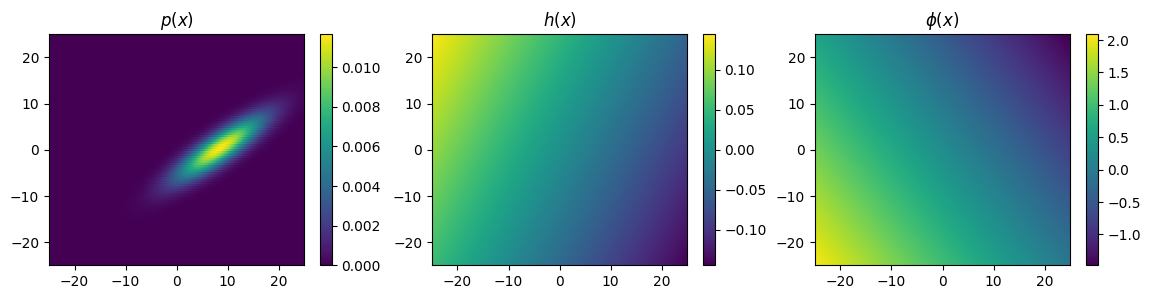

<Figure size 640x480 with 0 Axes>

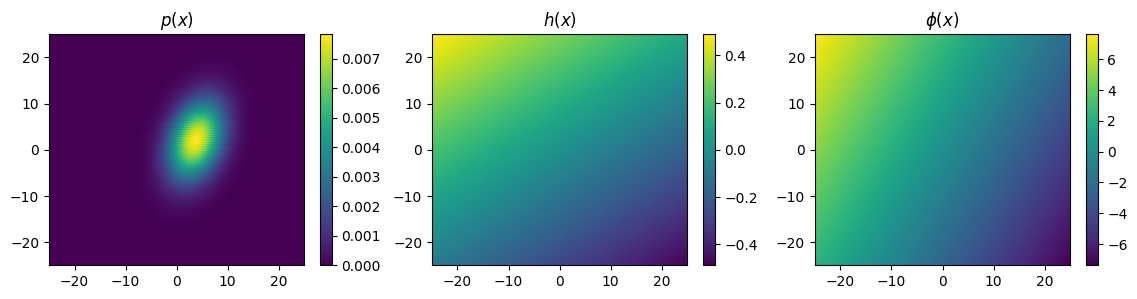

<Figure size 640x480 with 0 Axes>

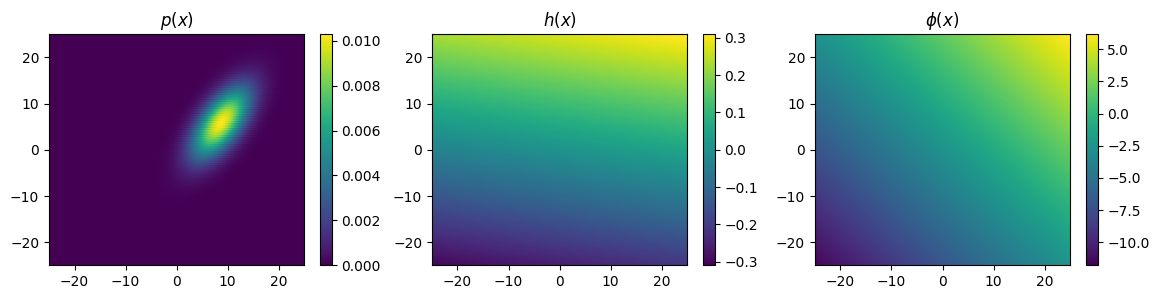

<Figure size 640x480 with 0 Axes>

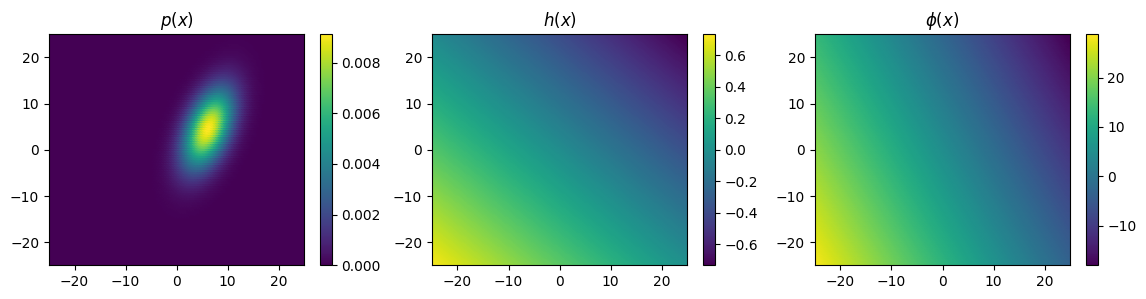

<Figure size 640x480 with 0 Axes>

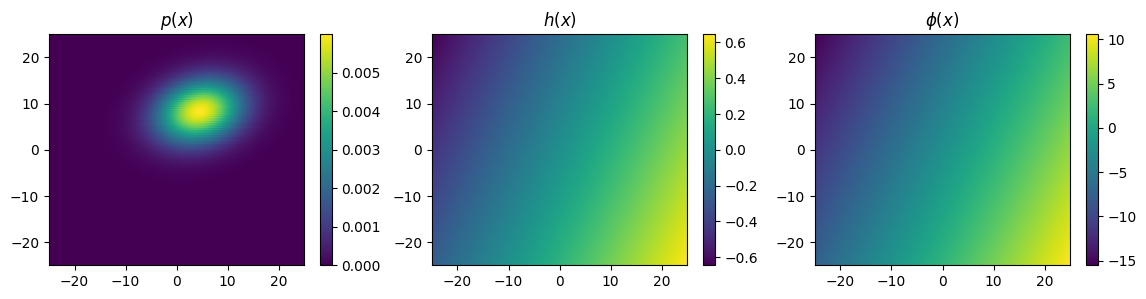

<Figure size 640x480 with 0 Axes>

In [81]:
ax = []
ux = []
for i in range(1000):
    dist = random_dist(d, loc=10, scale=36)
    H = torch.randn(m, d) * 1e-2
    px = torch.exp(dist.log_prob(X.T))[None, ...]
    hx = (H @ X.flatten(1)).reshape((m, N, N))
    ϕx = ϕ(X.flatten(1), dist.loc[:, None], dist.covariance_matrix, H).reshape((m, N, N))

    if i < 5:
        _ = plot_functions(X, px, hx, ϕx)
        _ = plt.show()
        _ = plt.clf()

    ax.append(torch.concat([px, hx], dim=0))
    ux.append(ϕx)

ax = torch.stack(ax)
ux = torch.stack(ux)
    

In [97]:
import os
data_dir = f'data/{str(dt.date.today())}'
os.makedirs(data_dir, exist_ok=True)

In [100]:
torch.save(ax, os.path.join(data_dir, 'ax.pt'))
torch.save(ux, os.path.join(data_dir, 'ux.pt'))